In [1]:
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#read in data
current_year = datetime.datetime.now().year
person= pd.read_csv("../data/person.csv")
measurement_only=pd.read_csv("../data/measurement.csv")
measurement=pd.merge(person,measurement_only,on="person_id")
person_age = current_year - measurement["year_of_birth"]
norm_ranges=pd.read_csv("../data/normal_ranges.csv")


In [3]:
#age will be used to set age specific ranges for tests
measurement.insert(loc=2,column="person_age",value=person_age,allow_duplicates=True)
#for ranges that are not age or sex specific, we have some established values
measurement.loc[measurement["measurement_source_value"]=="lbscat_wbc, White Blood Cells (WBC) - x10E3/µL","range_low"]=3.4
measurement.loc[measurement["measurement_source_value"]=="lbscat_wbc, White Blood Cells (WBC) - x10E3/µL","range_high"]=10.8

measurement.loc[measurement["measurement_source_value"]=="lbscat_rbc, Red Blood Cells (RBC) - x10E6/µL","range_low"]=3.77
measurement.loc[measurement["measurement_source_value"]=="lbscat_rbc, Red Blood Cells (RBC) - x10E6/µL","range_high"]=5.28

#hemoglobin
measurement.loc[measurement["measurement_source_value"]=="lbscat_a1c, Hemoglobin - g/dL","range_low"]=11.1
measurement.loc[measurement["measurement_source_value"]=="lbscat_a1c, Hemoglobin - g/dL","range_high"]=15.9
#hematocrit
measurement.loc[measurement["measurement_source_value"]=="lbscat_hct, Hematocrit  - %","range_low"]=34.0
measurement.loc[measurement["measurement_source_value"]=="lbscat_hct, Hematocrit  - %","range_high"]=46.6
#mcv
measurement.loc[measurement["measurement_source_value"]=="lbscat_mcv, MCV - fL","range_low"]=79
measurement.loc[measurement["measurement_source_value"]=="lbscat_mcv, MCV - fL","range_high"]=97
#mch
measurement.loc[measurement["measurement_source_value"]=="lbscat_mch, MCH - pg","range_low"]=26.6
measurement.loc[measurement["measurement_source_value"]=="lbscat_mch, MCH - pg","range_high"]=33
#mchc
measurement.loc[measurement["measurement_source_value"]=="lbscat_mchc, MCHC - g/dL","range_low"]=31.5
measurement.loc[measurement["measurement_source_value"]=="lbscat_mchc, MCHC - g/dL","range_high"]=35.7
#rdw
measurement.loc[measurement["measurement_source_value"]=="lbscat_rdw, RDW - %","range_low"]=11.7
measurement.loc[measurement["measurement_source_value"]=="lbscat_rdw, RDW - %","range_high"]=15.4
#platelets
measurement.loc[measurement["measurement_source_value"]=="lbscat_plt, Platelets - x10E3/µL","range_low"]=150
measurement.loc[measurement["measurement_source_value"]=="lbscat_plt, Platelets - x10E3/µL","range_high"]=450
#HDL
measurement.loc[measurement["measurement_source_value"]=="HDL Cholesterol (mg/dL)","range_high"]=300
#urine creatinine
measurement.loc[measurement["measurement_source_value"]=="Urine Creatinine (ug/mL)","range_low"]=700
measurement.loc[measurement["measurement_source_value"]=="Urine Creatinine (ug/mL)","range_high"]=2000
#urine albumin
measurement.loc[measurement["measurement_source_value"]=="Urine Albumin (ug/mL)","range_low"]=0
measurement.loc[measurement["measurement_source_value"]=="Urine Albumin (ug/mL)","range_high"]=30
#correct a data entry error
measurement.loc[(measurement["measurement_source_value"]=="lbscat_hct, Hematocrit  - %") &
        (measurement["person_id"]==4050),"value_as_number"]=41.3
norm_ranges = norm_ranges.reset_index()  # make sure indexes pair with number of rows
#update measurement dataframe with low/high ranges for each patient
for index, row in norm_ranges.iterrows():
    measure_concept=row["measurement_concept_id"]
    sex=row["gender_concept_id"]
    age_low=row["age_low"]
    age_high=row["age_high"]
    low_normal=row["low_normal"]
    high_normal=row["high_normal"]
    if sex!=3:
        measurement.loc[(measurement["measurement_concept_id"]==measure_concept) &
                (measurement["gender_concept_id"]==sex) &
                (measurement["person_age"] >=age_low) &
                (measurement["person_age"]<=age_high),"range_low"]=low_normal
        measurement.loc[(measurement["measurement_concept_id"]==measure_concept) &
                (measurement["gender_concept_id"]==sex) &
                (measurement["person_age"] >=age_low) &
                (measurement["person_age"]<=age_high),"range_high"]=high_normal
    else:
        measurement.loc[(measurement["measurement_concept_id"]==measure_concept) &
                (measurement["person_age"] >=age_low) &
                (measurement["person_age"]<=age_high),"range_low"]=low_normal
        measurement.loc[(measurement["measurement_concept_id"]==measure_concept) &
                (measurement["person_age"] >=age_low) &
                (measurement["person_age"]<=age_high),"range_high"]=high_normal


In [4]:
#specify panel tests
LABS_panel=["NT-proBNP (pg/mL)","Troponin-T (ng/L)","C-Peptide (ng/mL)","INSULIN (ng/mL)",
        "CRP - HS (mg/L)","Total Cholesterol (mg/dL)","HDL Cholesterol (mg/dL)", "LDL Cholesterol Calculation (mg/dL)",
        "LDL Cholesterol Calculation (mg/dL)","Triglycerides (mg/dL)", "Glucose (mg/dL)",
        "BUN (mg/dL)","Creatinine (mg/dL)","Sodium (mEq/L)","Potassium (mEq/L)","Chloride (mEq/L)",
        "Carbon Dioxide, Total (mEq/L)","Calcium (mg/dL)","Protein, Total (g/dL)",
        "Albumin (g/dL)","Bilirubin, Total (mg/dL)", "Alkaline Phosphatase (IU/L)","AST (IU/L)",
        "ALT (IU/L)","HbA1c (%)"]
CBC_panel=["lbscat_wbc, White Blood Cells (WBC) - x10E3/µL",
        "lbscat_rbc, Red Blood Cells (RBC) - x10E6/µL",
        "lbscat_a1c, Hemoglobin - g/dL","lbscat_hct, Hematocrit  - %",
        "lbscat_mcv, MCV - fL","lbscat_mch, MCH - pg",
        "lbscat_mchc, MCHC - g/dL","lbscat_rdw, RDW - %","lbscat_plt, Platelets - x10E3/µL"]
all_panel=LABS_panel + CBC_panel
#subset measurement dataframe with just the tests of interest
measurement=measurement[measurement["measurement_source_value"].isin(all_panel)]
labs_concept_id=measurement.loc[measurement["measurement_source_value"].isin(LABS_panel),"measurement_concept_id"]
cbc_concept_id=measurement.loc[measurement["measurement_source_value"].isin(CBC_panel),"measurement_concept_id"]


In [6]:
#create dictionaries that will be used for figure generation
person_id=measurement["person_id"]
person_dict=dict.fromkeys(person_id)
person_dict_range=dict.fromkeys(person_id)
person_ids=np.array(list(person_dict.keys()))

measurement_concept_id=measurement["measurement_concept_id"]
measurement_concept_dict=dict.fromkeys(measurement_concept_id)
measurement_concept_min_max_dict=dict.fromkeys(measurement_concept_id)
measurement_concept_ids=np.array(list(measurement_concept_dict.keys()))

measurement_concept_dict=dict.fromkeys(measurement_concept_ids)
measurement_concept_min_max_dict=dict.fromkeys(measurement_concept_ids)
measurement_concept_values_dict=dict.fromkeys(measurement_concept_ids)
#get range of each concept id
for measurement_concept in measurement_concept_ids:
       min_val=min(measurement.loc[measurement["measurement_concept_id"]==measurement_concept,"range_low"])
       max_val=max(measurement.loc[measurement["measurement_concept_id"]==measurement_concept,"range_high"])
       measurement_concept_dict[measurement_concept]=[min_val,max_val]
for measurement_concept in measurement_concept_ids:
       min_val=min(measurement.loc[measurement["measurement_concept_id"]==measurement_concept,"value_as_number"])
       max_val=max(measurement.loc[measurement["measurement_concept_id"]==measurement_concept,"value_as_number"])
       measurement_concept_min_max_dict[measurement_concept]=[0,max_val]
for measurement_concept in measurement_concept_ids:
       measurement_source_value=list(dict.fromkeys(measurement.loc[measurement["measurement_concept_id"]==measurement_concept,"measurement_source_value"]))[0]
       measurement_concept_values_dict[measurement_concept]=measurement_source_value
for person in person_ids:
       pt_val_dict={}
       for measurement_concept in measurement_concept_ids:
               pt_val=measurement.loc[(measurement["person_id"]==person) &
                (measurement["measurement_concept_id"]==measurement_concept),"value_as_number"]
               if pt_val.size>0:
                 pt_val_dict[measurement_concept]=pt_val
               else:
                 pt_val_dict[measurement_concept]=pd.Series(0.0)
       person_dict[person]=pt_val_dict
for person in person_ids:
       pt_range_dict={}
       for measurement_concept in measurement_concept_ids:
               pt_range_low=measurement.loc[(measurement["person_id"]==person) &
                (measurement["measurement_concept_id"]==measurement_concept),"range_low"]
               pt_range_high=measurement.loc[(measurement["person_id"]==person) &
                (measurement["measurement_concept_id"]==measurement_concept),"range_high"]
               if pt_range_low.size>0:
                pt_range_dict[measurement_concept]=[pt_range_low.to_numpy()[0],pt_range_high.to_numpy()[0]]
               else:
                pt_range_dict[measurement_concept]=[0.0,0.0]
       person_dict_range[person]=pt_range_dict



In [7]:
#either labs or cbc
PANEL_TO_USE="cbc"
panel_concept_id=cbc_concept_id

ex_ranges={k: measurement_concept_dict[k] for k in panel_concept_id}
use_category_names = ['Below Min','Within Range','Above Max']

ex_min_max={k: measurement_concept_min_max_dict[k] for k in panel_concept_id}
ex_concept_vals={k: measurement_concept_values_dict[k] for k in panel_concept_id}


In [13]:
#main function to produce plots
def make_plots(test_ranges,test_min_max,pt_ranges2,pt_low_high,category_names,concept_values,panel):
    """
    Parameters
    ----------
    test_ranges : dict
        A mapping from test id to low and high values.
    test_min_max : dict
        A mapping from test id to min and max values.
    pt_ranges2: dict
        A mapping from test name to patient value. Assumes just one patient
    category_names : list of str
        The category labels.
    concept_values: dict
        Mapping from test concept id to testname
    """
    text_adj=0.1
    text_size=35
    marker_adj=0.075
    marker_size=20
    pad_adj=0.001
    low_high_text_dict={"facecolor":'yellow', "alpha":.1, "pad":.1}
    labels = list(test_ranges.keys())
    #use pt specific test ranges
    test_ranges={k: pt_low_high[k] for k in labels}
    #ranges for all
    #pt specific ranges
    data={k: pt_low_high[k] for k in labels}
    data=np.array(list(data.values()))
    min_max=np.array(list(test_min_max.values()))
    start=np.zeros(shape=(len(data),1))
    ranges=np.zeros(shape=(len(data),1))
    end=np.zeros(shape=(len(data),1))
    scale_val=np.zeros(shape=(len(data),1))
    scale_val_low=np.zeros(shape=(len(data),1))
    scale_val_high=np.zeros(shape=(len(data),1))

    for idx,_ in enumerate(data):
        start[idx]=15
        ranges[idx]=70
        end[idx]=15
        if abs(data[idx][1] - min_max[idx][1]) > 15:
            scale_val_high[idx]= 15.0/abs(data[idx][1]-min_max[idx][1])
        else:
            scale_val_high[idx]= abs(min_max[idx][1]-data[idx][1])/15
        if data[idx][0]>0:
            scale_val_low[idx]=15/data[idx][0]
        else:
            scale_val_low[idx]=1
        if (data[idx][1]-data[idx][0])>70:
            scale_val[idx]=70.0/(data[idx][1]-data[idx][0])
        else:
            if data[idx][1]!=data[idx][0]:
                scale_val[idx]=70.0/(data[idx][1]-data[idx][0])
            else:
                scale_val[idx]=1
        if data[idx][0]==data[idx][1]:
            start[idx]=0
            ranges[idx]=min_max[idx][1]-min_max[idx][0]
            scale_val[idx]=1
            end[idx]=0
    data2 = np.transpose((start.ravel(),ranges.ravel(),end.ravel()))
    data_cum = data2.cumsum(axis=1)
    #only need this when we take a subset of test measurements
    pt_ranges=dict((k, pt_ranges2[k]) for k in labels if k in pt_ranges2)
    pt_data = np.array(list(pt_ranges.values()))
    category_colors=("yellow","green","yellow")
    for test,_ in enumerate(test_ranges):
        plt.figure(figsize=(10,2))
        plt.tight_layout()
        plt.ylim(0,.2)
        plt.tick_params(axis="y",width=.1)
        plt.margins(y=0)
        plt.grid(False)
        plt.xticks(ticks=[15,85], labels=[list(test_ranges.values())[test][0],list(test_ranges.values())[test][1]])
        plt.tick_params(axis='x', labelsize=40)
        plt.xlim(0,100)
        for i, (_, color) in enumerate(zip(category_names, category_colors)):
            widths = data2[test, i]
            starts = data_cum[test, i] - widths
            if panel=="labs":
                #rects = plt.barh(y_pos[test], width=widths, left=starts, height=0.025, color=color)
                rects = plt.barh(0, width=widths, left=starts, height=.1,color=color,align="center")
            else:
                rects = plt.barh(0, width=widths, left=starts, height=.1,color=color,align="center")

            plt.yticks([])
            if (panel=="cbc"):
                plt.title(label=re.sub(".*,","",concept_values[labels[test]]).strip().title(),fontsize=40,loc="center",y=1,fontweight="bold",pad=0)
            else:
                plt.title(label=concept_values[labels[test]].strip().title(),fontsize=40,loc="center",y=1,fontweight="bold",pad=0)
            if pt_data[test]< data[test,0]:
              text=plt.text(x=(pt_data[test]*scale_val_low[test]),y=text_adj,s=str(np.round(pt_data[test][0],2)), ha='center',va = 'bottom',bbox=low_high_text_dict,fontsize=text_size)
              plt.plot(pt_data[test]*scale_val_low[test],marker_adj,marker='v', linestyle="",alpha=0.8, color="tab:olive",markersize=marker_size)
            elif pt_data[test]>data[test,1] and data[test,1] >=0:
              text=plt.text(x=85+(pt_data[test]*scale_val_high[test]),y=text_adj,s=str(np.round(pt_data[test][0],2)), ha='center',va = 'bottom', bbox=low_high_text_dict,fontsize=text_size)
                #text = plt.annotate("High", xycoords=text, xy=(1.5, 1), ha='center',verticalalignment="top",bbox=dict(facecolor = 'tab:olive', alpha =.1,pad=pad_adj),fontsize=text_size)  # custom properties
              plt.plot(85+(pt_data[test]*scale_val_high[test]),marker_adj,marker='v', linestyle="",alpha=0.8, color="tab:olive",markersize=marker_size)
            else:
              if data[test,0]>0:
                text=plt.text(x=15+((pt_data[test]-data[test,0])*scale_val[test]),y=text_adj,s=str(np.round(pt_data[test][0],2)), ha='center',va = 'bottom',bbox={"facecolor" : 'green', "alpha" : .1,"pad" : pad_adj},fontsize=text_size)
                plt.plot(15+((pt_data[test]-data[test,0])*scale_val[test]),marker_adj,marker='v', linestyle="",alpha=0.8, color="g",markersize=marker_size)
              else:
                text=plt.text(x=15+(pt_data[test]*scale_val[test]),y=text_adj,s=str(np.round(pt_data[test][0],2)), ha='center',va = 'bottom',bbox={"facecolor" : 'green', "alpha" : .1,"pad" : pad_adj},fontsize=text_size)
                plt.plot(15+(pt_data[test]*scale_val[test]),marker_adj,marker='v', linestyle="",alpha=0.8, color="g",markersize=marker_size)
        for pos in ['right', 'top', 'bottom', 'left']:
            plt.gca().spines[pos].set_visible(False)

        plot_name=""
        if panel=="cbc":
            plot_name=re.sub(" ","_",re.sub(" \\(.*","",re.sub(".*, ","",re.sub(" - .*","",concept_values[labels[test]]))))
        if panel=="labs":
            plot_name=re.sub(",.*","",re.sub(" \\(.*","",concept_values[labels[test]]))
        #for saving
        #plt.savefig(panel+"_extreme2/"+panel+"_"+plot_name+".jpg",bbox_inches='tight',pad_inches=0)
        #for displaying
        plt.show()
        plt.close()



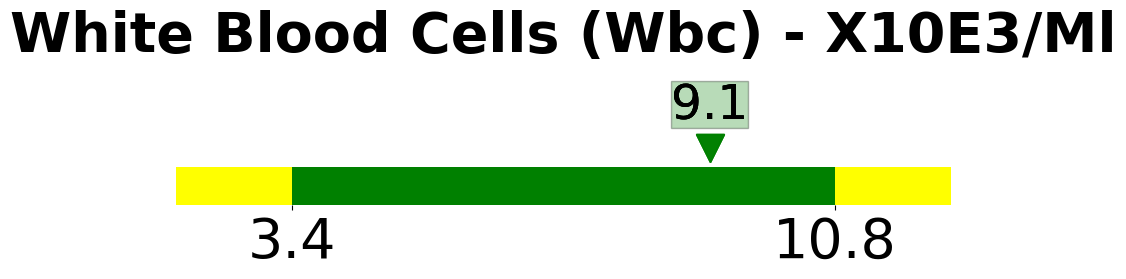

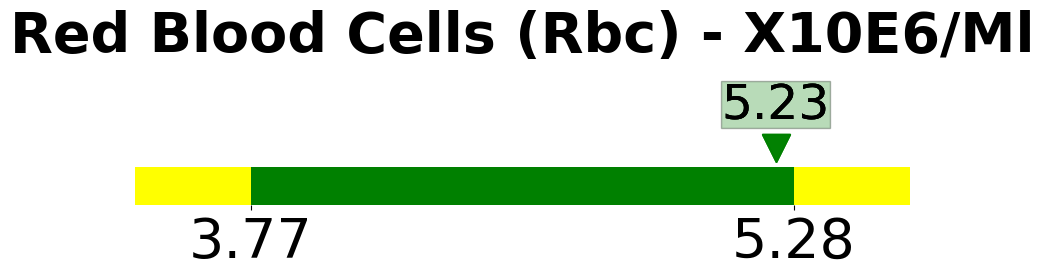

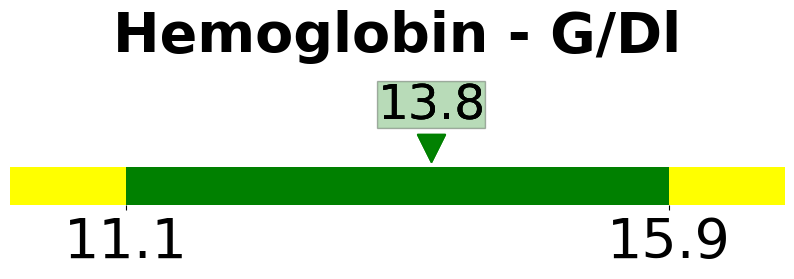

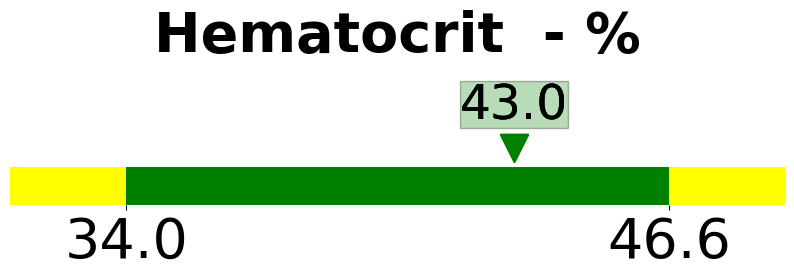

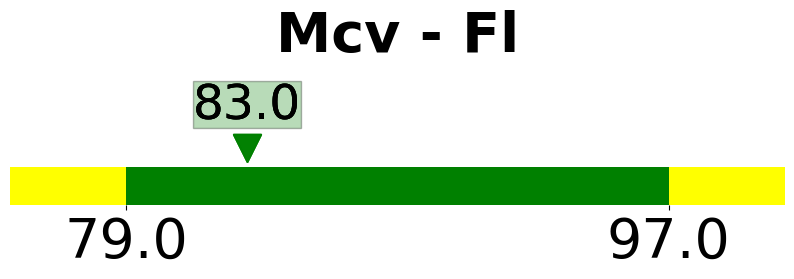

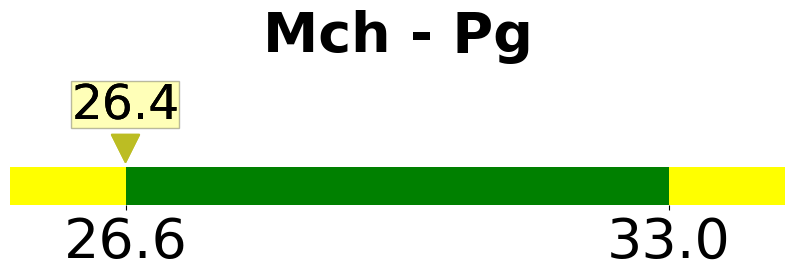

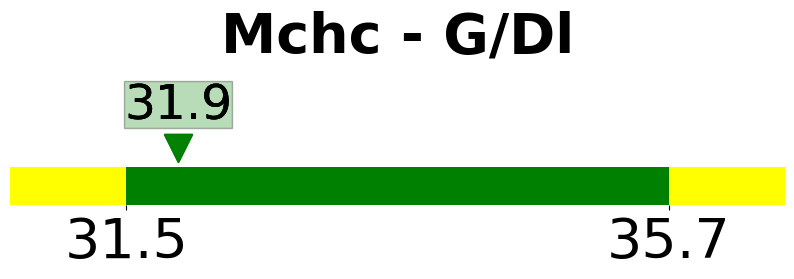

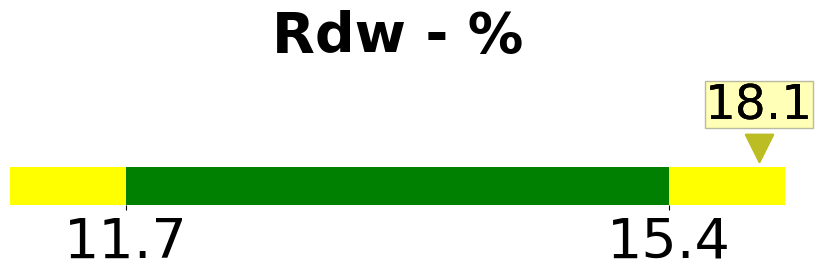

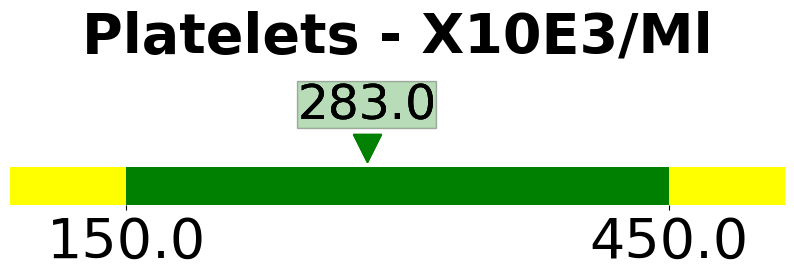

In [14]:
#test out of range
person_dict2=person_dict[1018].copy()
pt_range_dict2=person_dict_range[1018].copy()
make_plots(ex_ranges,ex_min_max,person_dict2,pt_range_dict2,use_category_names,ex_concept_vals,PANEL_TO_USE)
